# CA03: Using Decision Tree Algorithm on Census Bureau Data

<i>
Dani Le, Efren Lopez, Luis Otero
<br>
BSAN 6070
<br>
February 14, 2024
<br>
</i>

GitHub Links:
*   Dani: https://github.com/ledani-bu/ml
*   Efren: https://github.com/efrenlop01/
*   Luis: https://github.com/otero106/BSAN6070

## Table of Contents
* [Project Overview](#overview)
* [Python Implementation](#python)
    * [Data Source and Contents](#data_source)
    * [Data Quality Analysis](#dqa)
    * [Build Decision Tree Classifier Models](#decision_tree)
    * [Evaluate Decision Tree Performance](#tree_performance)
    * [Tune Decision Tree Performance](#tune_performance)
    * [Visualizing Best Decision Tree using GraphViz](#visual)
    * [Conclusion](#conclusion)
    * [Making a Prediction Using the Best Model](#prediction)

## Project Overview <a class="anchor" id="overview"></a>

In this Python project, we will be utilizing the decision tree algorithms from the scikit-learn library on a salary dataset obtained from the Census Bureau. Decision tree is a supervised machine learning algorithm in which it takes a whole dataset and keeps splitting it into subsets based on the attributes until a certain criteria is met. The end result is a flowchart-like tree structure consisting of nodes that represent rows that meet certain attributes within the dataset, branches that represent the outcome of the node and leaf nodes (terminal nodes) that hold a class label. 

The dataset contains eleven columns with nine demographic variables, one indicating whether the row is to be used in the training or test set, and one target class (0 or 1). The target variable indicates whether the person has a salary that is greater than 50K or less than 50K. The main objective of this project is to construct several decision tree models and to select the "best" one to use for predicting, this will be determined using several metrics such as accuracy, recall, and precision. However; before we dive into modelling, we must first load, explore and understand the data that we will be working with

## Python Implementation <a class="anchor" id="python"></a>

### Part 1: Data Source and Contents <a class="anchor" id="data_source"></a>

In [1]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
%matplotlib inline

In [2]:
#loading data
data = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')

#brief summary of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


In [3]:
#looking at first five rows
data.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


#### <b> Question 1: Why does it makes sense to discretize columns for this problem? <b>

In the data sample shown above, we can see that apart from the target variable, 'y', all the columns are categorical with each value being a data group or bin, with the exception of the 'flag' column. Discretization is a data cleaning technique of converting a dataframe's continuous-valued columns into discrete or categorical columns by the means of binning. This makes sense for this project as we are dealing with a classification problem and decision trees is one classification model that performs better with discrete values. The use of bins minimizes the number of overall unique feature values and will speed up the training process of modelling. 

#### <b> Question 2: What might be the issues (if any) if we DID NOT discretize the columns? <b>

If we had the columns stored as numerical data with their original continuous values, the decision tree algorithm would make countless attribute partitions and will make the duration of model training longer. Additionally, we will be visualizing our decision tree models later on in this project and if we had done with continuous data, the viz would appear difficult to read and extremely complex. With discretization, the data appears simpler and the decision tree will yield more accurate results.

### Part 2: Data Quality Analysis (DQA) <a class="anchor" id="dqa"></a>

#### Checking Quality of Data

In [4]:
#check for missing values
data.isnull().sum()

hours_per_week_bin    0
occupation_bin        0
msr_bin               0
capital_gl_bin        0
race_sex_bin          0
education_num_bin     0
education_bin         0
workclass_bin         0
age_bin               0
flag                  0
y                     0
dtype: int64

In [5]:
#select duplicate rows
duplicate = data[data.duplicated()]

#number of duplicate rows
print('Number of duplicate rows:', duplicate.shape[0])

Number of duplicate rows: 40012


The data appears to not have any missing values whatsoever but the majority of records within the dataset are duplicates. We originally trained our models with the dataset that had the duplicates removevd but this resulted in lower performance metrics. For the sake of constructing the best model, we will keep the duplicates.

#### Descriptive and Summary Statistics

In [6]:
#descriptive statistics
data.describe(include='object')

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,5,5,3,3,3,5,5,2,5,2
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561


In [7]:
#display unique values and their counts for each column
col_list = ['hours_per_week_bin', 'occupation_bin', 'msr_bin', 'capital_gl_bin', 'race_sex_bin', 'education_num_bin','education_bin', 'workclass_bin', 'age_bin']

for col in col_list:
    print(data[col].value_counts())
    print('–––––––––––––––––––––––––––––––––––––––-')

b. 31-40            26639
d. 41-50 & 61-70     9819
a. 0-30              7851
e. 51-60             3759
c. 71-100             774
Name: hours_per_week_bin, dtype: int64
–––––––––––––––––––––––––––––––––––––––-
c. Mid - Mid     13971
b. Mid - Low     12947
e. High          12258
a. Low            7237
d. Mid - High     2429
Name: occupation_bin, dtype: int64
–––––––––––––––––––––––––––––––––––––––-
c. High    22047
b. Mid     15868
a. Low     10927
Name: msr_bin, dtype: int64
–––––––––––––––––––––––––––––––––––––––-
a. = 0    42525
c. > 0     4035
b. < 0     2282
Name: capital_gl_bin, dtype: int64
–––––––––––––––––––––––––––––––––––––––-
c. High    29737
b. Mid     16457
a. Low      2648
Name: race_sex_bin, dtype: int64
–––––––––––––––––––––––––––––––––––––––-
b. 9-12    30324
c. 13       8025
a. 0-8      6408
d. 14       2657
e. 15+      1428
Name: education_num_bin, dtype: int64
–––––––––––––––––––––––––––––––––––––––-
b. Mid          30324
c. Bachelors     8025
a. Low           6408


In [8]:
#display percentage of unique values for each column as % format
for col in col_list:
    print(data[col].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')
    print('–––––––––––––––––––––––––––––––––––––––-')

b. 31-40            54.5%
d. 41-50 & 61-70    20.1%
a. 0-30             16.1%
e. 51-60             7.7%
c. 71-100            1.6%
Name: hours_per_week_bin, dtype: object
–––––––––––––––––––––––––––––––––––––––-
c. Mid - Mid     28.6%
b. Mid - Low     26.5%
e. High          25.1%
a. Low           14.8%
d. Mid - High     5.0%
Name: occupation_bin, dtype: object
–––––––––––––––––––––––––––––––––––––––-
c. High    45.1%
b. Mid     32.5%
a. Low     22.4%
Name: msr_bin, dtype: object
–––––––––––––––––––––––––––––––––––––––-
a. = 0    87.1%
c. > 0     8.3%
b. < 0     4.7%
Name: capital_gl_bin, dtype: object
–––––––––––––––––––––––––––––––––––––––-
c. High    60.9%
b. Mid     33.7%
a. Low      5.4%
Name: race_sex_bin, dtype: object
–––––––––––––––––––––––––––––––––––––––-
b. 9-12    62.1%
c. 13      16.4%
a. 0-8     13.1%
d. 14       5.4%
e. 15+      2.9%
Name: education_num_bin, dtype: object
–––––––––––––––––––––––––––––––––––––––-
b. Mid          62.1%
c. Bachelors    16.4%
a. Low          

#### Data Quality Report

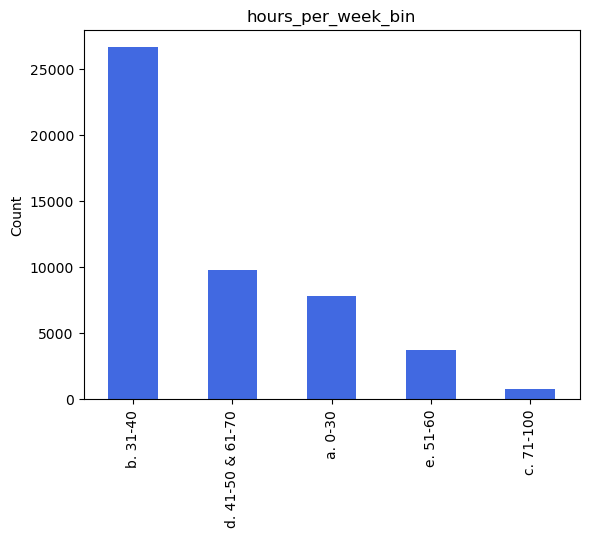

<Figure size 800x500 with 0 Axes>

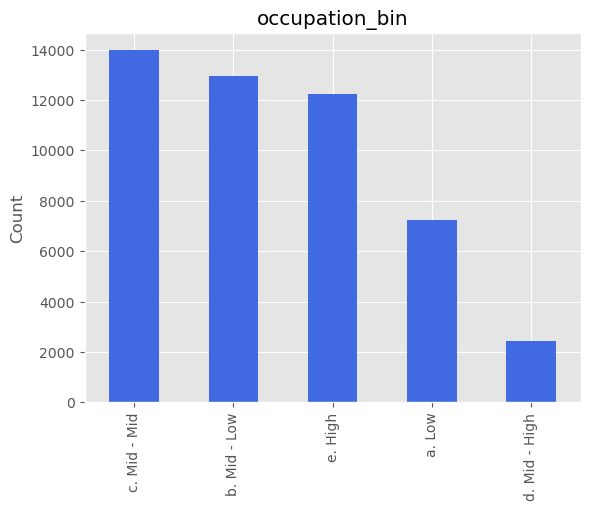

<Figure size 800x500 with 0 Axes>

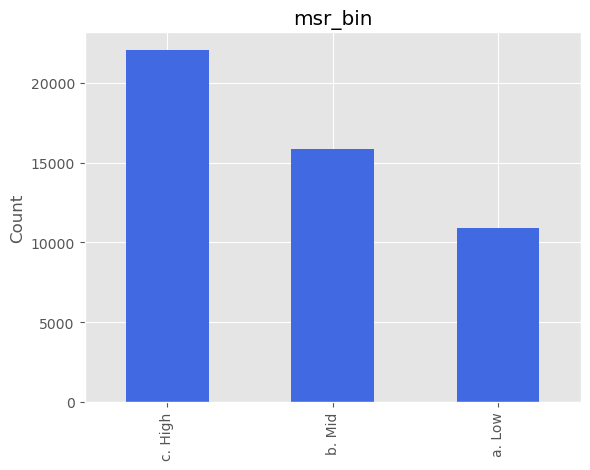

<Figure size 800x500 with 0 Axes>

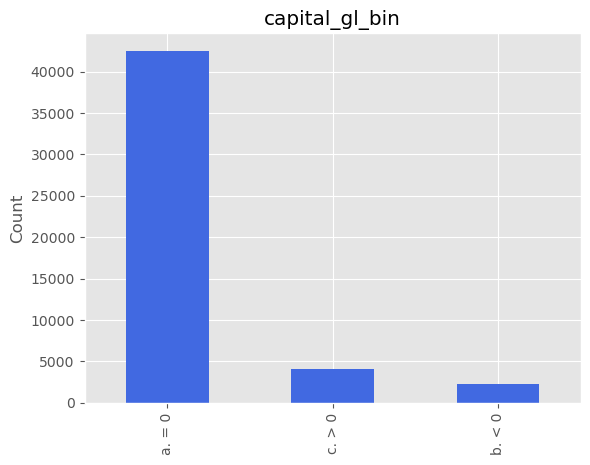

<Figure size 800x500 with 0 Axes>

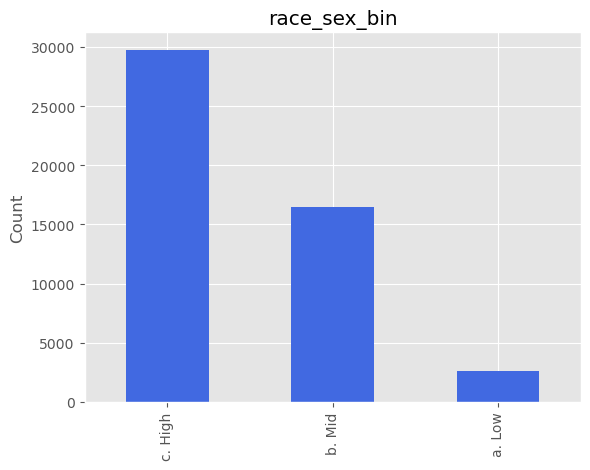

<Figure size 800x500 with 0 Axes>

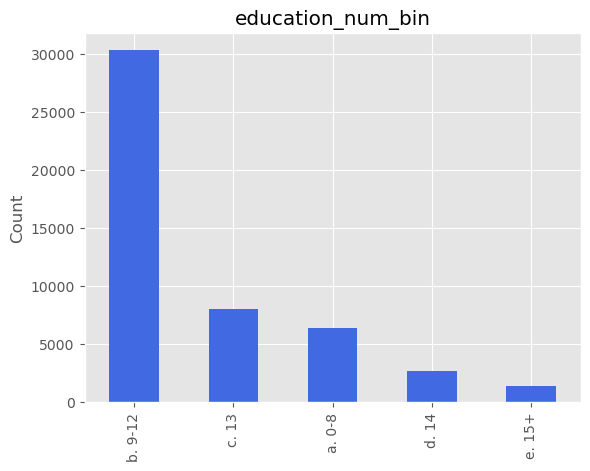

<Figure size 800x500 with 0 Axes>

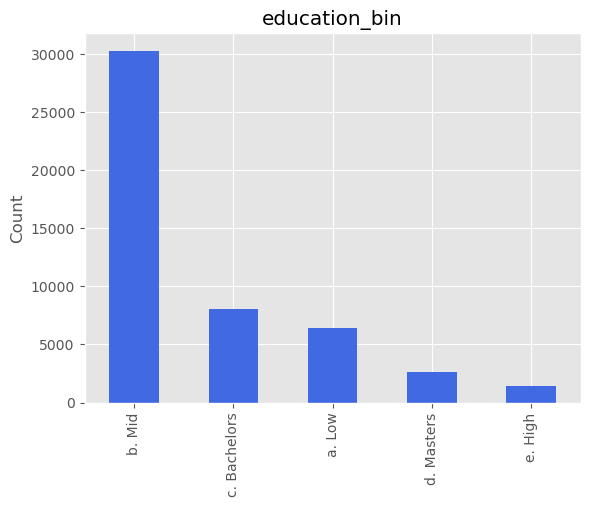

<Figure size 800x500 with 0 Axes>

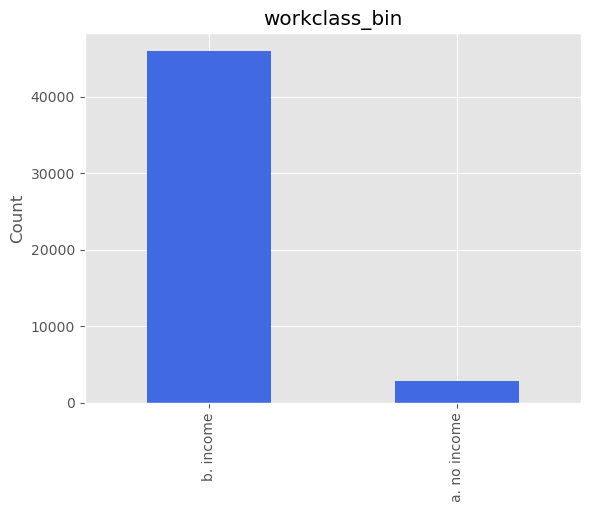

<Figure size 800x500 with 0 Axes>

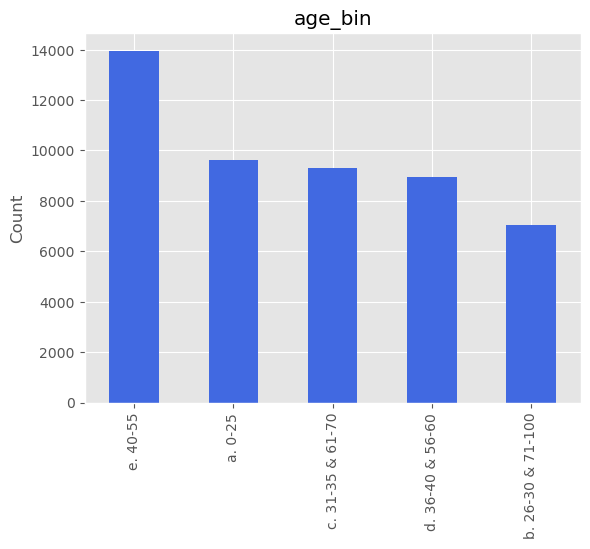

<Figure size 800x500 with 0 Axes>

In [9]:
#visualize distribution of each column using bar charts
for col in col_list:
    data[col].value_counts().plot(kind='bar', ylabel='Count', color = 'royalblue')
    plt.title(col)
    plt.style.use('ggplot')
    plt.figure(figsize=(8,5))
    plt.show()

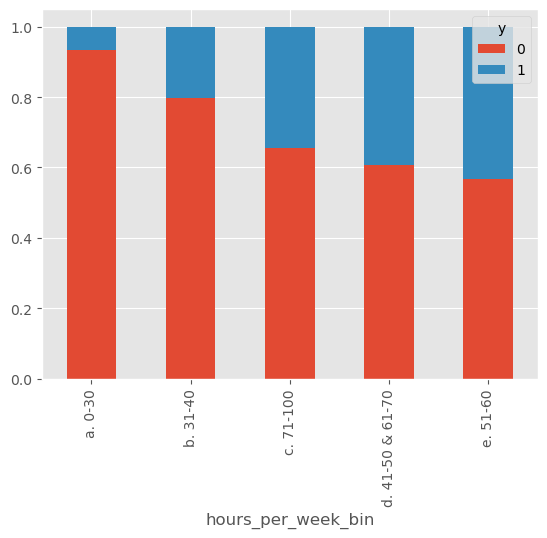

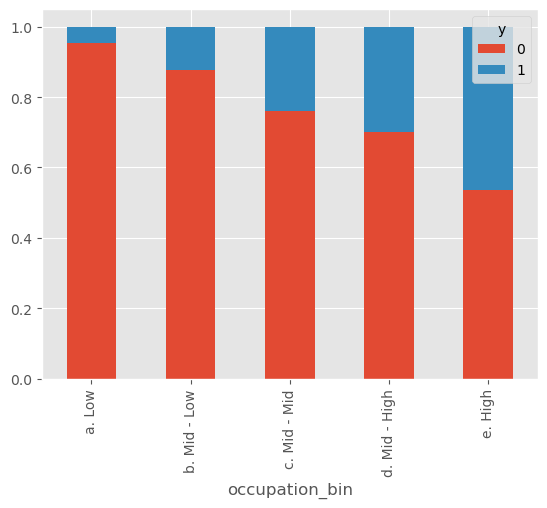

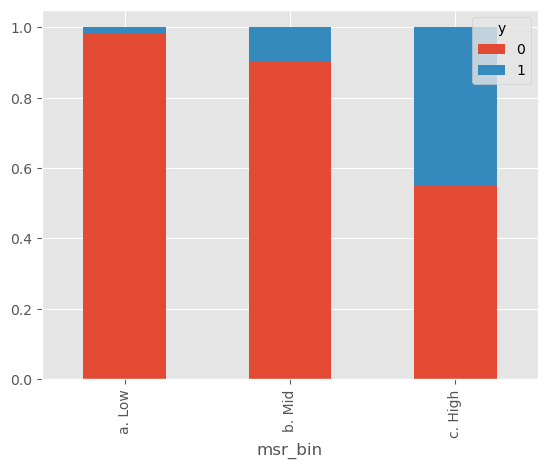

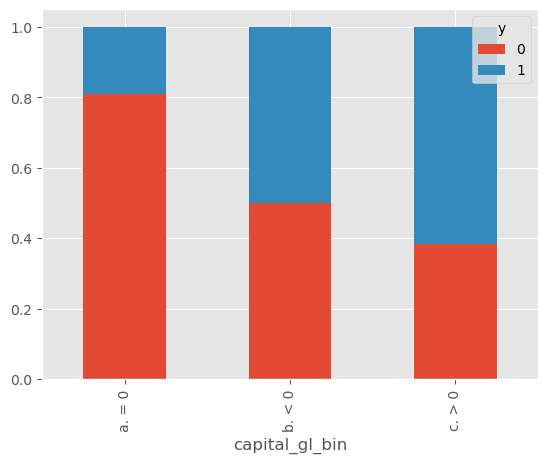

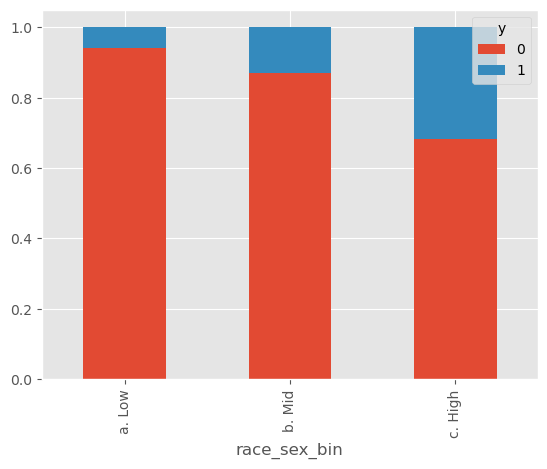

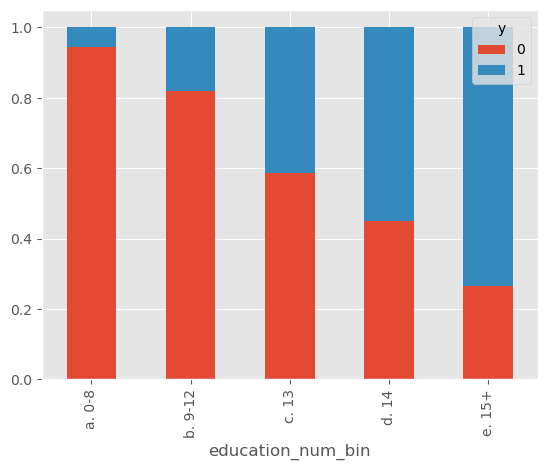

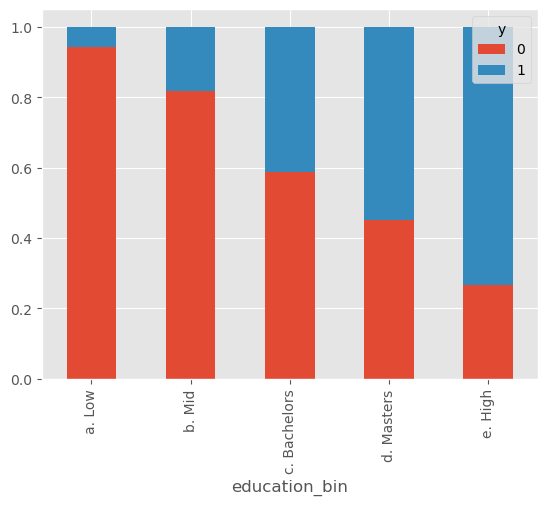

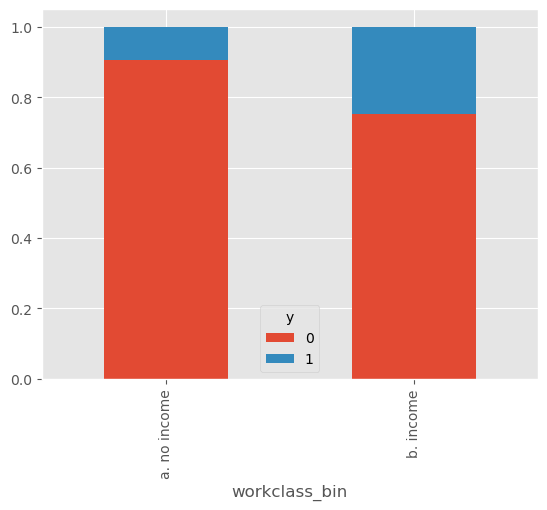

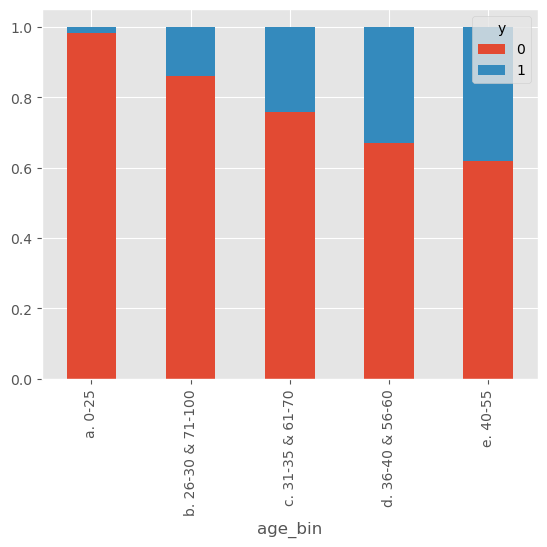

In [10]:
#visualize distribution of target variable
for col in col_list:
    pd.crosstab(data[col],data['y'],normalize='index').plot(kind='bar',stacked=True)

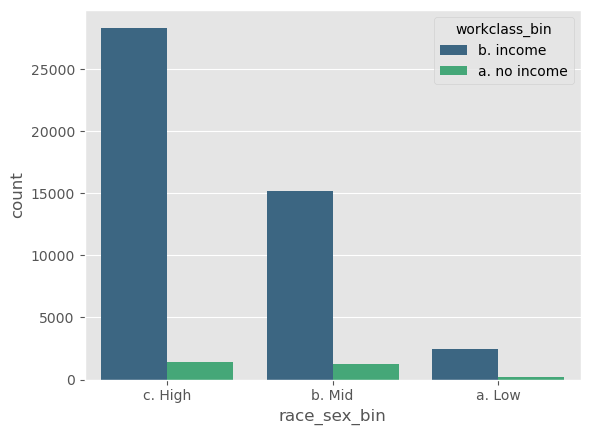

In [11]:
#countplot visualizing count of race_sex_bin by workclass_bin
sns.countplot(x='race_sex_bin', hue='workclass_bin', data=data, palette='viridis')
plt.show()

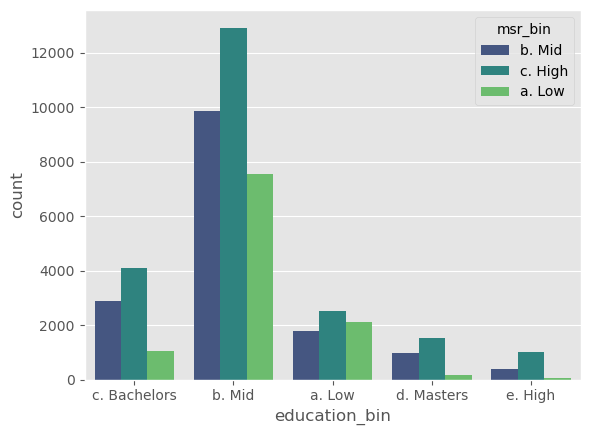

In [12]:
#countplot visualizing count of education_bin by msr_bin
sns.countplot(x='education_bin', hue='msr_bin', data=data, palette='viridis')
plt.show()

#### Data Pre-Processing

In [13]:
#create a copy of the data
data_copy = data.copy()

#get rid of first 3 characters
for col in col_list:
    data_copy[col] = data_copy[col].str[3:]

data_copy.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,income,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,income,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,income,36-40 & 56-60,train,0
3,31-40,Low,High,= 0,Mid,0-8,Low,income,40-55,train,0
4,31-40,High,High,= 0,Low,13,Bachelors,income,26-30 & 71-100,train,0


In [14]:
#create dummy variables for every categorical column
data_dummies = pd.get_dummies(data_copy, columns=col_list, drop_first=True)

#see new columns
data_dummies.head()

,flag,y,hours_per_week_bin_31-40,hours_per_week_bin_41-50 & 61-70,hours_per_week_bin_51-60,hours_per_week_bin_71-100,occupation_bin_Low,occupation_bin_Mid - High,occupation_bin_Mid - Low,occupation_bin_Mid - Mid,...,education_num_bin_9-12,education_bin_High,education_bin_Low,education_bin_Masters,education_bin_Mid,workclass_bin_no income,age_bin_26-30 & 71-100,age_bin_31-35 & 61-70,age_bin_36-40 & 56-60,age_bin_40-55
0,train,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,train,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,train,0,1,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,train,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,train,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


The only data preparation conducted was converting all the categorical columns into dummy variables since we will be utilizing a classification model.

#### Creating Training and Test Sets

In [15]:
#split the data into traininig and testing sets using 'flag' column
train = data_dummies[data_dummies['flag'] == 'train']
test = data_dummies[data_dummies['flag'] == 'test']

#drop 'flag' column from both train and test sets
train.drop('flag', axis=1, inplace=True)
test.drop('flag', axis=1, inplace=True)

print("Number of rows in training set:", train.shape[0])
print("Number of rows in test set:", test.shape[0])

Number of rows in training set: 32561
Number of rows in test set: 16281


/var/folders/1l/tdn0y83s4tg7r1s7ymj8phd40000gn/T/ipykernel_9071/1856958666.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop('flag', axis=1, inplace=True)
/var/folders/1l/tdn0y83s4tg7r1s7ymj8phd40000gn/T/ipykernel_9071/1856958666.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('flag', axis=1, inplace=True)


In [16]:
#split the training set into features and target variable
x_train = train.drop('y', axis=1)
y_train = train['y']

#split the test set into features and target variable
x_test = test.drop('y', axis=1)
y_test = test['y']

#see first five rows of new datasets
print(x_train.head())
print(y_train.head())
print(x_test.head())
print(y_test.head())

   hours_per_week_bin_31-40  hours_per_week_bin_41-50 & 61-70  \
0                         1                                 0   
1                         0                                 0   
2                         1                                 0   
3                         1                                 0   
4                         1                                 0   

   hours_per_week_bin_51-60  hours_per_week_bin_71-100  occupation_bin_Low  \
0                         0                          0                   0   
1                         0                          0                   0   
2                         0                          0                   1   
3                         0                          0                   1   
4                         0                          0                   0   

   occupation_bin_Mid - High  occupation_bin_Mid - Low  \
0                          0                         1   
1                       

### Part 3: Build Decision Tree Classifier Models <a class="anchor" id="decision_tree"></a>

In [17]:
#initialize the decision tree classifier
dtree = DecisionTreeClassifier(max_depth = 10, random_state = 75,
                               max_features = None, min_samples_leaf = 15)

#fit (train) the model
dtree.fit(x_train, y_train)

#test the model (make predictions)
y_pred = dtree.predict(x_test)

### Part 4: Evaluate Decision Tree Performance <a class="anchor" id="tree_performance"></a>

Text(50.72222222222221, 0.5, 'Actual')

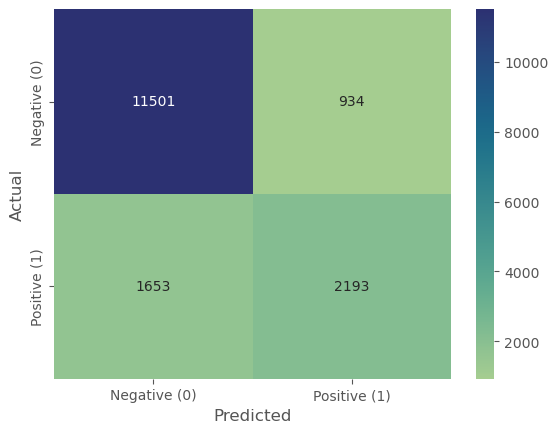

In [18]:
#calculate and display confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='crest', fmt='d', 
            xticklabels= ['Negative (0)', 'Positive (1)'], yticklabels= ['Negative (0)', 'Positive (1)'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [19]:
#calculate and display accuracy score
accuracy_score(y_test, y_pred)

0.8411031263435906

In [20]:
#display classification report (accuracy, precision, recall, f1-score)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.92      0.90     12435
           1       0.70      0.57      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.75      0.76     16281
weighted avg       0.83      0.84      0.84     16281



### Part 5: Tune Decision Tree Performance <a class="anchor" id="tune_performance"></a>

#### Q3: Decision Tree Hyperparameter Variation vs. Performance

#### Run 1: Finding Best Split Criteria


In [21]:
#using entropy as criterion
dtree1 = DecisionTreeClassifier(criterion = 'entropy', random_state = 75)

#using gini as criterion
dtree2 = DecisionTreeClassifier(criterion = 'gini', random_state = 75)

In [22]:
#calculate accuracy, precision, recall, and f1-score for each model
#empty list to store results
results1 = []

#loop through each model
for model in [dtree1, dtree2]:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    criterion = model.criterion
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #store results in list, converting list to dictionary
    results1.append({'criterion': criterion, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

#display results as a dataframe
pd.DataFrame(results1)

,criterion,accuracy,precision,recall,f1
0,entropy,0.836988,0.692258,0.557982,0.617910
1,gini,0.836312,0.690300,0.556942,0.616492


#### Run 2: Finding Best Minimum Sample Leaf

In [23]:
#construct decision trees with the provided minimum sample leaf values
results2 = []

#list of values to try for minimum sample leaf
min_sample_leaf = [5, 10, 15, 20, 25, 30, 35, 40]

#loop through each value
for leaf in min_sample_leaf:
    model = DecisionTreeClassifier(criterion = 'entropy', random_state = 75, min_samples_leaf = leaf)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #store results in list, converting list to dictionary
    results2.append({'min_samples_leaf': leaf, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

#display results as a dataframe
pd.DataFrame(results2)

,min_samples_leaf,accuracy,precision,recall,f1
0,5,0.840673,0.704709,0.560322,0.624276
1,10,0.841472,0.709091,0.557722,0.624363
2,15,0.841779,0.706840,0.564223,0.627530
3,20,0.841779,0.705502,0.566823,0.628604
4,25,0.841779,0.708197,0.561622,0.626450
5,30,0.841902,0.715447,0.549142,0.621359
6,35,0.843069,0.712405,0.562923,0.628903
7,40,0.843253,0.714665,0.560062,0.627988


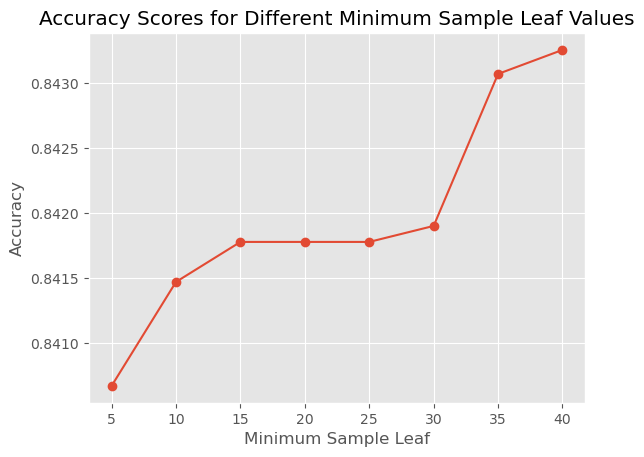

In [24]:
#line graph of accuracy scores for each minimum sample leaf value
#store accuracy scores in a list
accuracy_scores = [score['accuracy'] for score in results2]

#plot the line graph
plt.plot(min_sample_leaf, accuracy_scores, marker='o')
plt.xlabel('Minimum Sample Leaf')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Minimum Sample Leaf Values')
plt.show()

#### Run 3: Finding Best Maximum Feature

In [25]:
#construct models with the provided maximum feature values
results3 = []

#list of values to try for maximum feature
max_feature = ['auto', None, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

#loop through each value
for feature in max_feature:
    model = DecisionTreeClassifier(criterion = 'entropy', random_state = 75, min_samples_leaf = 40, max_features = feature)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #store results in list, converting list to dictionary
    results3.append({'max_features': feature, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

#display results
pd.DataFrame(results3)

,max_features,accuracy,precision,recall,f1
0,auto,0.836804,0.695366,0.550182,0.614313
1,None,0.843253,0.714665,0.560062,0.627988
2,0.3,0.835268,0.701663,0.526521,0.601604
3,0.4,0.835452,0.685062,0.561622,0.617231
4,0.5,0.842516,0.715680,0.553042,0.623937
5,0.6,0.840120,0.708908,0.548362,0.618384
6,0.7,0.841287,0.706074,0.562142,0.625941
7,0.8,0.841594,0.704950,0.566563,0.628225


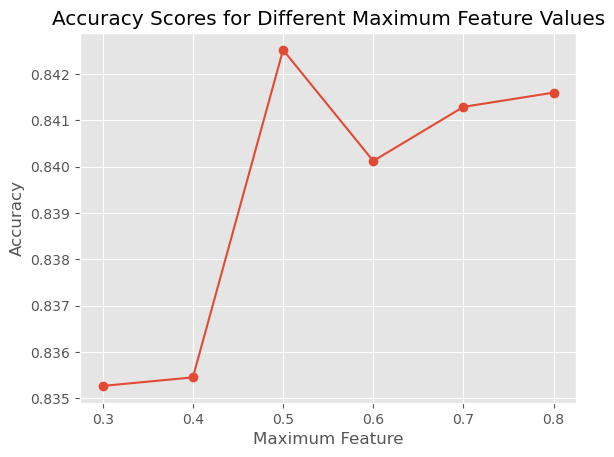

In [26]:
#line graph of accuracy scores for each maximum feature value
#store accuracy scores in a list
accuracy_scores = [score['accuracy'] for score in results3]

#take out first two values from accuracy_scores and max_feature
accuracy_scores = accuracy_scores[2:]
max_feature = max_feature[2:]

#plot the line graph
plt.plot(max_feature, accuracy_scores, marker='o')
plt.xlabel('Maximum Feature')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Maximum Feature Values')
plt.show()

#### Run 4: Finding Best Maximum Depth

In [27]:
#construct models with the provided maximum depth values
results4 = []

#list of values to try for maximum depth
max_depth = [2, 4, 6, 8, 10, 12, 14, 16]

#loop through each value
for depth in max_depth:
    model = DecisionTreeClassifier(criterion = 'entropy', random_state = 75, min_samples_leaf = 40, 
                                   max_features = 0.5, max_depth = depth)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #store results in list, converting list to dictionary
    results4.append({'max_depth': depth, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

#display results
pd.DataFrame(results4)

,max_depth,accuracy,precision,recall,f1
0,2,0.792089,0.652548,0.256370,0.368116
1,4,0.809533,0.690148,0.351534,0.465805
2,6,0.830047,0.721743,0.456578,0.559325
3,8,0.838523,0.726629,0.507280,0.597458
4,10,0.836988,0.704530,0.533801,0.607396
5,12,0.841656,0.700253,0.576443,0.632345
6,14,0.838953,0.727340,0.509100,0.598960
7,16,0.839383,0.724553,0.516381,0.603006


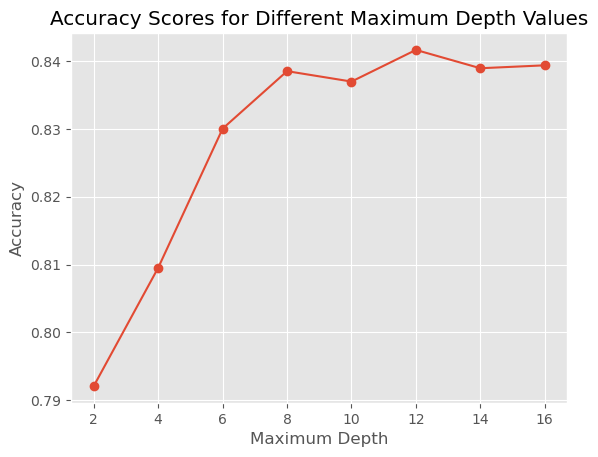

In [28]:
#line graph of accuracy scores for each maximum depth value
#store accuracy scores in a list
accuracy_scores = [score['accuracy'] for score in results4]

#plot the line graph
plt.plot(max_depth, accuracy_scores, marker='o')
plt.xlabel('Maximum Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Maximum Depth Values')
plt.show()

### Part 6: Visualizing Best Decision Tree using GraphViz <a class="anchor" id="visual"></a>

Accuracy Score of Training Set: 0.8418353244679218
Accuracy Score of Test Set: 0.8416559179411585


<AxesSubplot:>

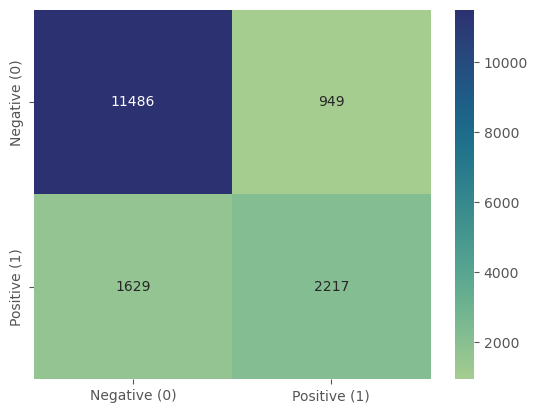

In [29]:
#constructing the best model
final_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 75, min_samples_leaf = 40,
                                    max_features=0.5, max_depth=12)

#fit the model
final_tree.fit(x_train, y_train)

#make predictions
y_pred = final_tree.predict(x_test)

#print accuracy score
print("Accuracy Score of Training Set:", accuracy_score(y_train, final_tree.predict(x_train)))
print("Accuracy Score of Test Set:", accuracy_score(y_test, y_pred))

#calculate and display confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='crest', fmt='d', 
            xticklabels= ['Negative (0)', 'Positive (1)'], yticklabels= ['Negative (0)', 'Positive (1)'])

In [30]:
#display classification report (accuracy, precision, recall, f1-score)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     12435
           1       0.70      0.58      0.63      3846

    accuracy                           0.84     16281
   macro avg       0.79      0.75      0.77     16281
weighted avg       0.83      0.84      0.84     16281



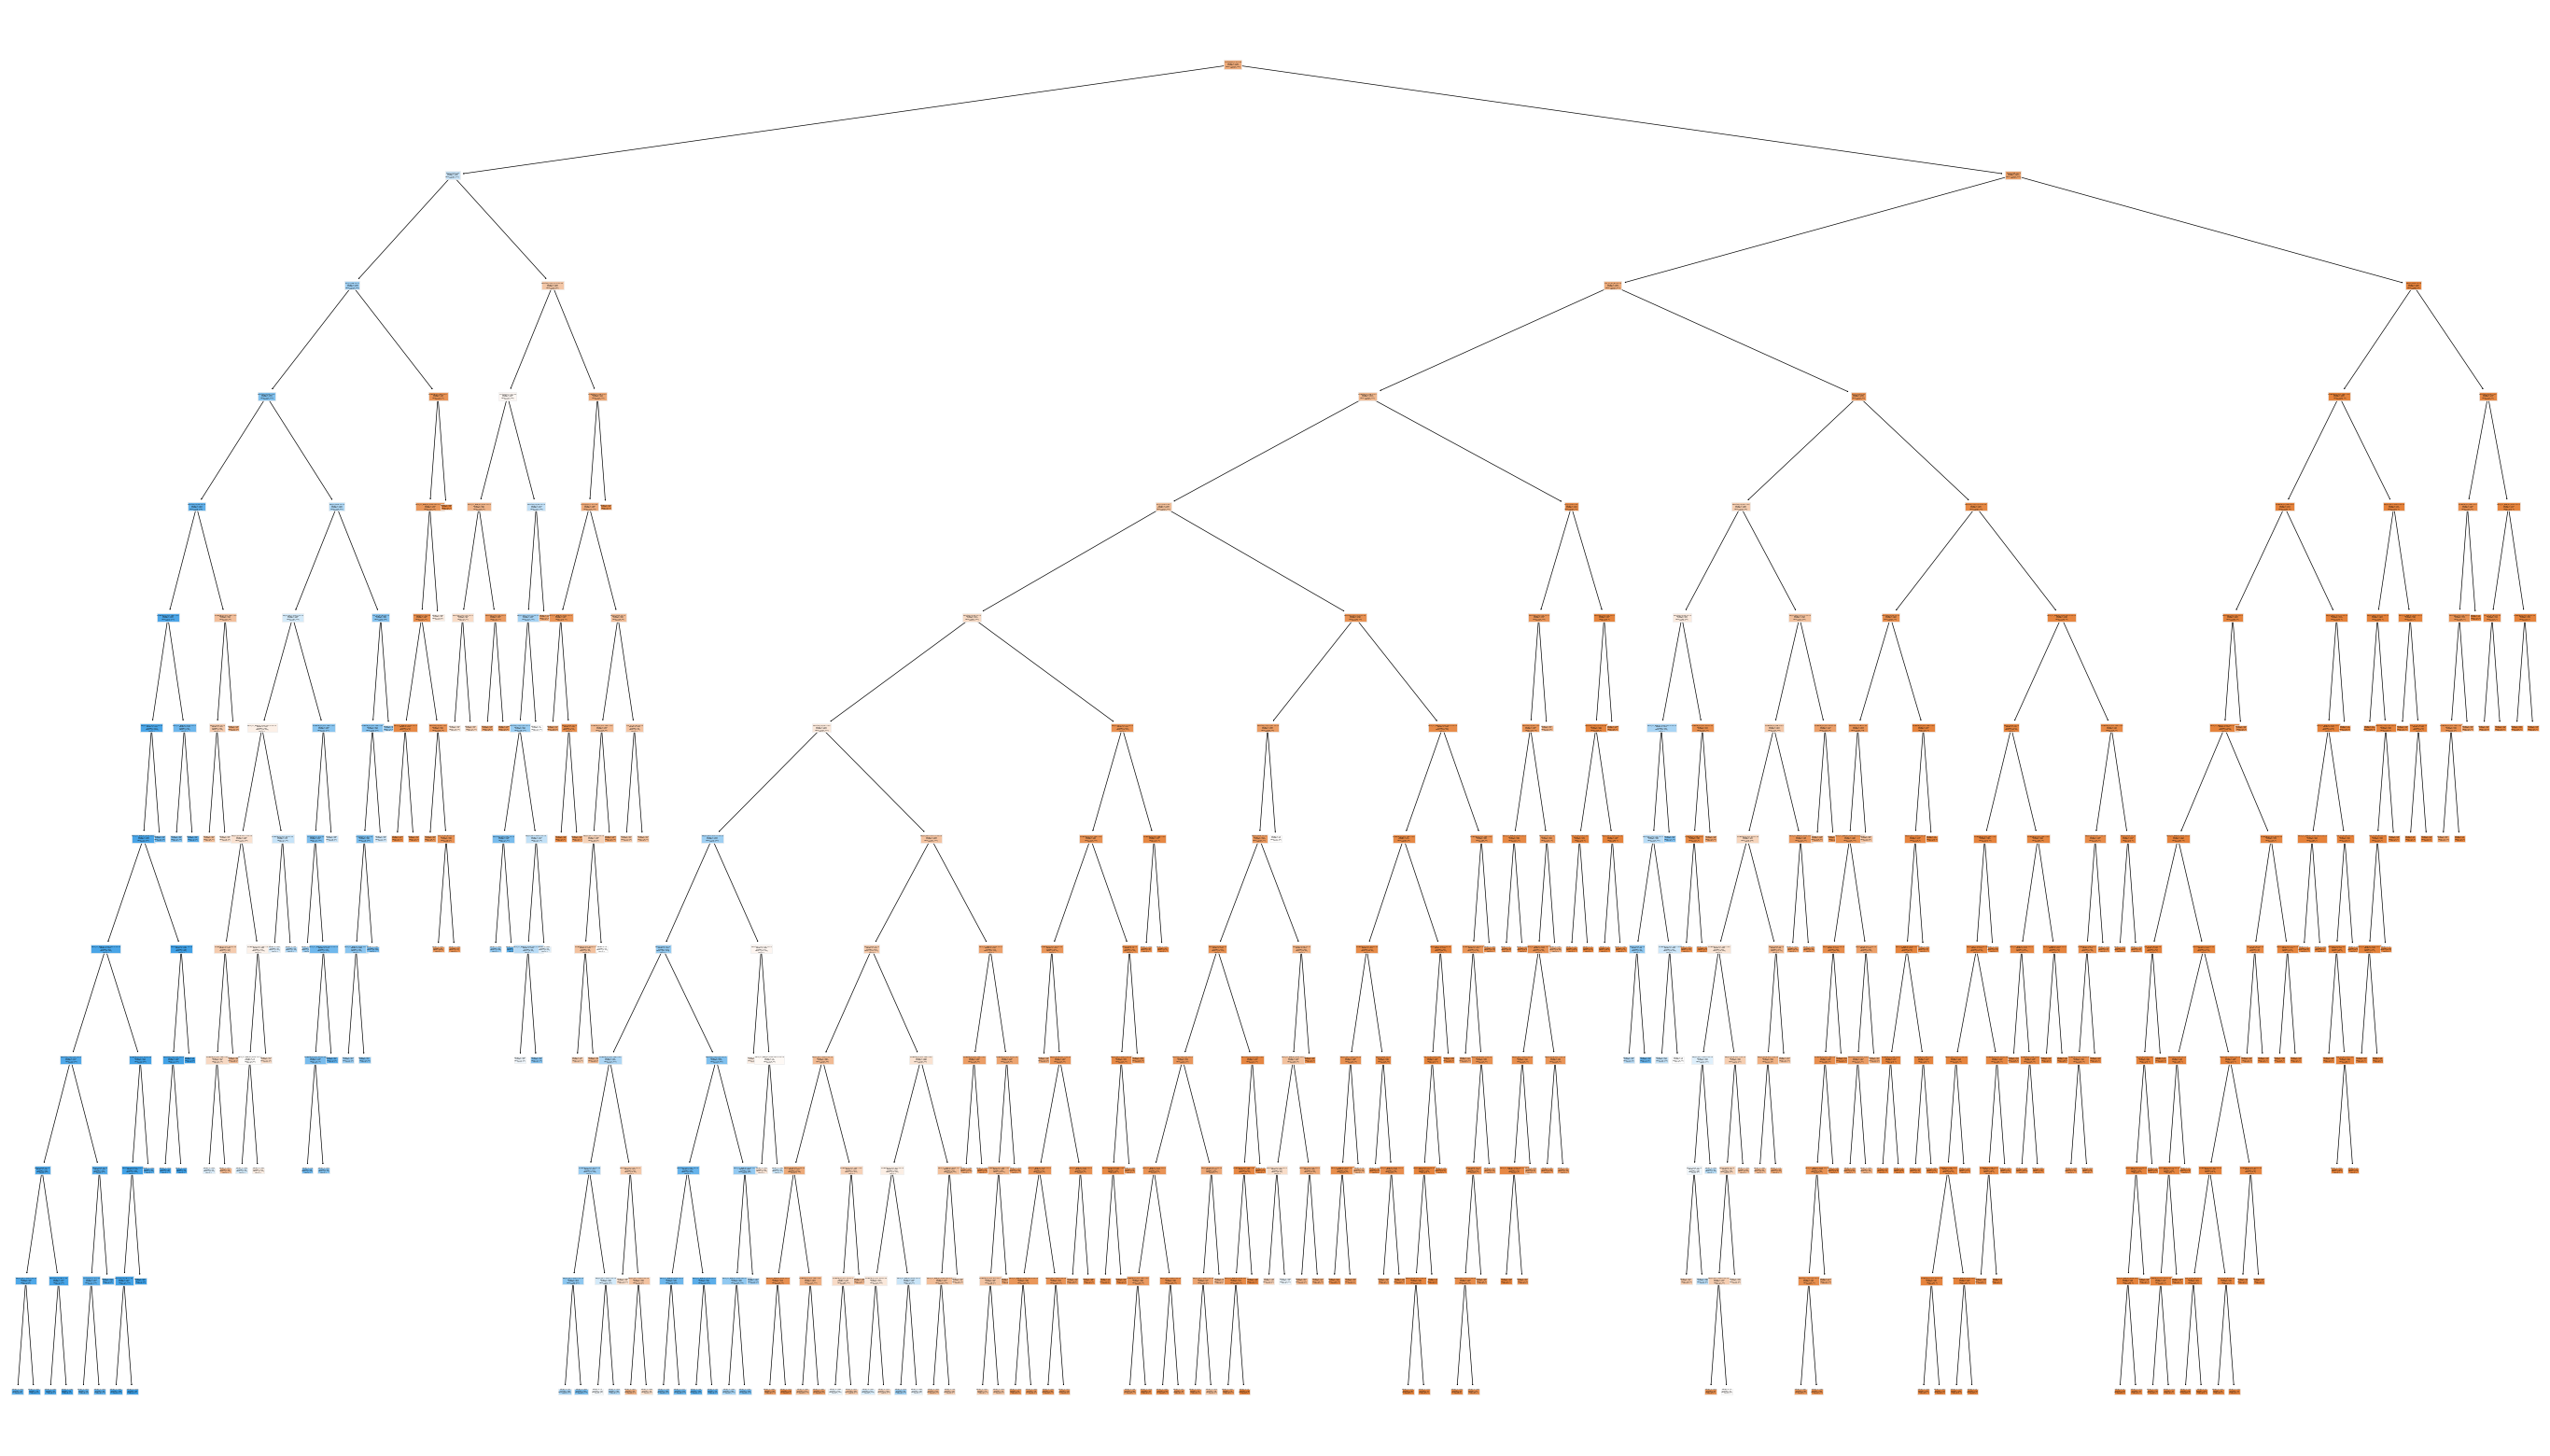

In [31]:
#plot the decision tree
plt.figure(figsize=(35,20))
tree.plot_tree(final_tree, filled=True, feature_names=x_train.columns, class_names=['0', '1'])
plt.show()

### Part 7: Conclusion <a class="anchor" id="conclusion"></a>

Overall, the decision tree tuning process did not improve the performance of our decision tree model as the accuracy score is still approximately 0.841.

#### <b> Q4: How long was your total run time to train the best model? </b>

The total runtime to train the best model was 0.1s.

#### <b> Q5: Did you find the BEST TREE? </b>

We used the following parameters construct our "best" tree:

- Criterion: Entropy
- Min Samples Leaf: 40
- Max Features: 0.5
- Max Depth: 12

However, we believe that we did NOT find the best tree. To find the best possible decision tree model, we can use Grid Search from Scikit-Learn.

#### <b> Q6: Write your observations from the visualization of the best tree </b>

Judging by the visualization, the decision tree appears to be very complex with many leaf nodes at the last level of the tree model. This is usually an indicator of overfitting.

#### <b> Q7: Will this Tree “overfit”? </b>

Overfitting is an issue that occurs when a model fits too closely to the training data and when it is used for testing or predicting future outcomes, the model may become less accurate. When a model is overfit, it memorizes the complexity and variance of the training set and would fail to recognize patterns in the data.

However, judging by the overall performance of the model, with an training set accuracy of 0.8418 and a test set accuracy of 0.8417, it is safe to say that the model is not overfitting as the accuracy stays relatively consistent. If it was overfitting, it would not perform well with the test data and/or the prediction.

### Part 8: Making a Prediction Using the Best Model <a class="anchor" id="prediction"></a>

In [32]:
#create copy of x_train
new_record = x_train.copy()

#clear all values in the new record
new_record = new_record.iloc[0:0]

#add new record into empty dataframe as a new row
new_row = ({'hours_per_week_bin_31-40': 0, 'hours_per_week_bin_41-50 & 61-70': 1,
       'hours_per_week_bin_51-60': 0, 'hours_per_week_bin_71-100':0,
       'occupation_bin_Low' : 0, 'occupation_bin_Mid - High' : 0,
       'occupation_bin_Mid - Low' : 1, 'occupation_bin_Mid - Mid': 0, 'msr_bin_Low' : 0,
       'msr_bin_Mid':0, 'capital_gl_bin_= 0':0, 'capital_gl_bin_> 0':1,
       'race_sex_bin_Low':0, 'race_sex_bin_Mid':1, 'education_num_bin_13':0,
       'education_num_bin_14':0, 'education_num_bin_15+':0,
       'education_num_bin_9-12':1, 'education_bin_High':1, 'education_bin_Low':0,
       'education_bin_Masters':0, 'education_bin_Mid':0, 'workclass_bin_no income':0,
       'age_bin_26-30 & 71-100':0, 'age_bin_31-35 & 61-70':0,
       'age_bin_36-40 & 56-60':1, 'age_bin_40-55':0})


new_record.loc[len(new_record)] = new_row

new_record


,hours_per_week_bin_31-40,hours_per_week_bin_41-50 & 61-70,hours_per_week_bin_51-60,hours_per_week_bin_71-100,occupation_bin_Low,occupation_bin_Mid - High,occupation_bin_Mid - Low,occupation_bin_Mid - Mid,msr_bin_Low,msr_bin_Mid,...,education_num_bin_9-12,education_bin_High,education_bin_Low,education_bin_Masters,education_bin_Mid,workclass_bin_no income,age_bin_26-30 & 71-100,age_bin_31-35 & 61-70,age_bin_36-40 & 56-60,age_bin_40-55
0,0,1,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,1,0


In [33]:
#make prediction for the new record
final_tree.predict(new_record)

#predict probability of the new record
final_tree.predict_proba(new_record)

array([[0.26415094, 0.73584906]])

#### <b> Q8: What is the probability that your prediction for this person is correct? </b>

The probaility that this person has an income of greater than 50K is approximately 73.58 while the probability of this person having an income of less than 50K is about 26.42%